# Определение возраста покупателей

## Исследовательский анализ данных

### Загрузка и изучение данных

Импортируем необходимые библиотеки и инструменты:

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

Загружаем данные:

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

labels.info()

Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Размер полученных данных:

In [4]:
labels.shape

(7591, 2)

При помощи функции next получим features и target из загруженных данных:

In [5]:
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

**Промежуточный итог:**
- имеем датасет из 7591 пар - фотография и возраст человека на фото
- фотографии размером 224х224 разделены на батчи по 32 объекта в каждом
- для обучения модели на всем датасете потребуется (7591/32)= 237 итераций за одну эпоху

### Распределение данных по возрасту людей на фото

Построим график распределения возраста в нашей выборке:

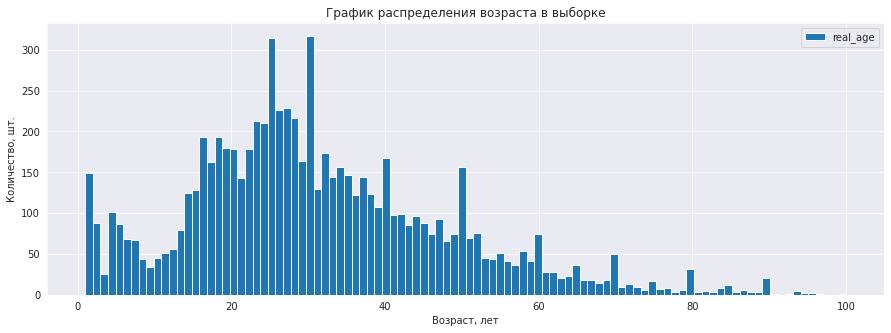

In [23]:
labels.plot(kind='hist',figsize=(15,5),bins=100, grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество, шт.')
plt.show()

Посмотрим на концентрацию данных о возрасте при помощи графика boxplot

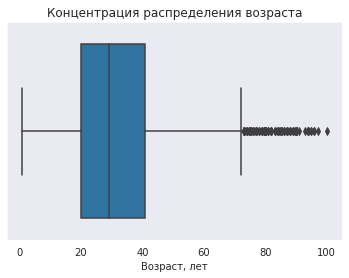

In [18]:
sns.boxplot(labels["real_age"])
plt.title('Концентрация распределения возраста')
plt.xlabel('Возраст, лет')
plt.show()

**Промежуточный итог:**
- по построенным графикам видим нормальное распределение со скосом вправо
- наибольшее количество фото приходится на людей в возрасте от 20 до 40 лет, видимо в связи с активностью людей этого возраста, а следствие - с большим количеством фотографий
- много фотографий маленьких детей, связано это скорее с желанием родителей чаще фотографировать своих деток
- выделяются также значения с юбилейной возрастной отметкой, фотографии долгую на память))

### Печать фото на экране

Выведем 15 фотографий и посмотрим на возможные сложности, которые могут возникнуть при их обработке нашей моделью

In [24]:
labels.head(15)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


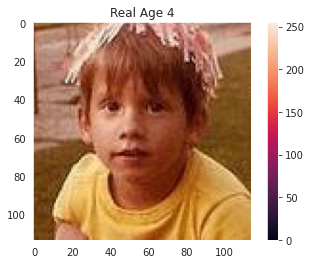

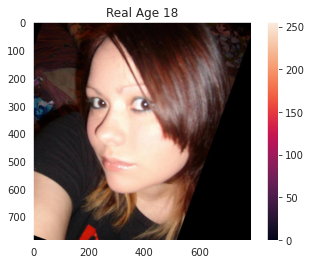

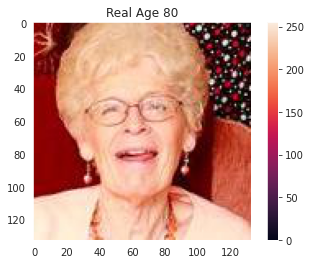

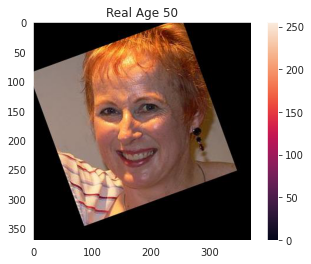

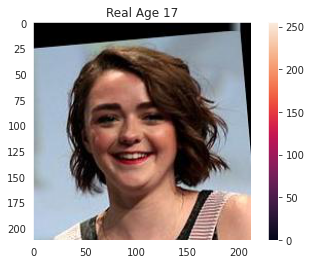

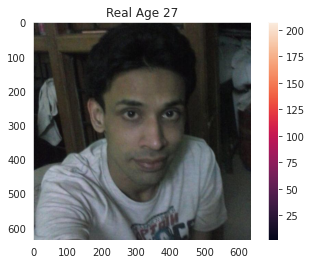

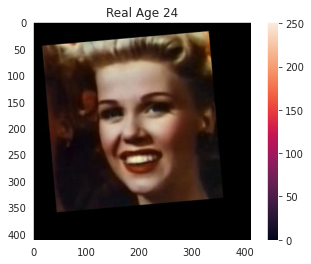

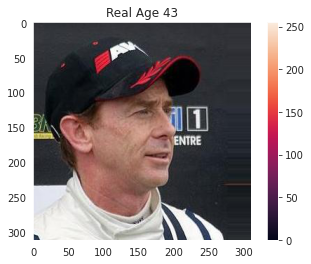

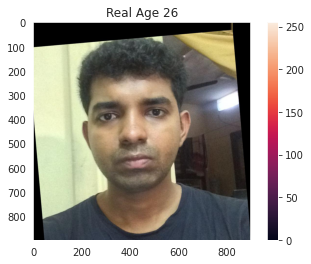

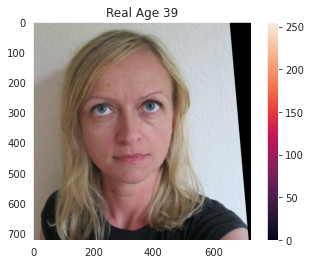

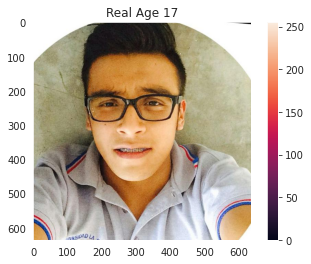

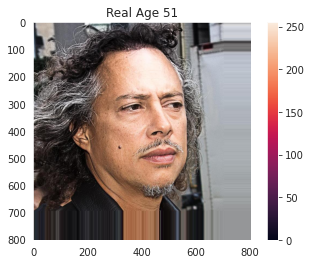

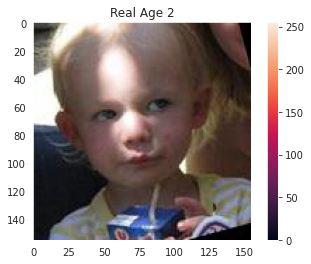

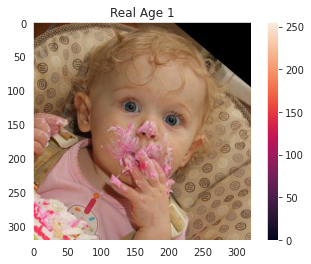

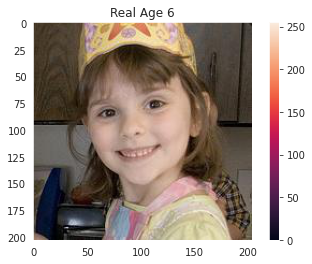

In [26]:
for i,k in zip(labels.file_name[:15],labels.real_age[:15]):
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    plt.imshow(array)
    plt.title('Real Age {:.0f}'.format(k))
    plt.colorbar()
    plt.show()

**Промежуточный итог:**

В исходных данных встречаются фото "неидеальные" для обучения модели:
- низкого качества
- повернутые и/или смещенные относительно центра 
- с недостаточной яркостью и/или контрастностью 
- в оттенках серого/красного 
- с размытой частью и т.д.

В целом количества данных в нашей выборке достаточно, для проведения обучения модели. Но для улучшения качества добавим аугментацию для тренировочной выборки, применим отражения по горизонтали и вертикали, а также добавим диапазон яркости изображений.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-08-04 13:06:04.401986: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-04 13:06:04.711024: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 55s - loss: 202.7982 - mae: 10.3390 - val_loss: 563.0013 - val_mae: 18.6802
Epoch 2/10
178/178 - 47s - loss: 97.9044 - mae: 7.4865 - val_loss: 572.9390 - val_mae: 18.7848
Epoch 3/10
178/178 - 46s - loss: 68.7491 - mae: 6.3186 - val_loss: 267.9726 - val_mae: 12.1101
Epoch 4/10
178/178 - 47s - loss: 54.1301 - mae: 5.5896 - val_loss: 181.3825 - val_mae: 10.1006
Epoch 5/10
178/178 - 47s - loss: 42.5989 - mae: 4.9689 - val_loss: 111.8570 - val_mae: 7.7940
Epoch 6/10
178/178 - 47s - loss: 33.7839 - mae: 4.4665 - val_loss: 75.5144 - val_mae: 6.4073
Epoch 7/10
178/178 - 47s - loss: 27.3302 - mae: 4.0022 - val_loss: 82.3048 - val_mae: 7.0955
Epoch 8/10
178/178 - 47s - loss: 21.8580 - mae: 3.5739 - val_loss: 74.3737 - val_mae: 6.6581
Epoch 9/10
178/178 - 47s - loss: 18.8152 - mae: 3.3552 - val_loss: 68.0215 - val_mae: 6.2277
Epoch 10/10
178/178 - 47s - loss: 15.6544 - mae: 3.0357 - val_loss: 90.5139 - val_mae: 6.9501
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 90.5139 - mae: 6.9501
Test MAE: 6.9501

```

Результат МАЕ на тесте ~6,95 получен за 10 эпох обучения модели, что соответсвует условию задачи МАЕ < 8. Полученная модель способна делать качественный прогноз по определению возраста человека по его фотографии.

## Анализ обученной модели

Перед нами стояла задача построить и обучить модель, которя поможет определять возраст человека по изображению с камеры со средним абсолютным отклонением МАЕ не выше 8. В нашем распоряжении был датасет с 7951 парой фотография-возраст человека на ней.

Для обучения модели мы использовали тренировачную выборку в соотношении 75% от исходной, добавив аугментацию отражения фото по горизонтальной и вертикальной осям, а также диапазон яркости изображений.

В качестве основы за модель взяли уже предобученную нейросеть с архитектурой ResNet50 и дополнительно обучили её на наших данных без замораживания. В выходном слое, для более точного обучения модели, использовали оптимизацию Adam c шагом обучения 0.0003, а в качестве функции потерь использовалась mean_squared_error, что немного ускорило процесс обучения.

Для обучения модели достаточно 10 эпох, судя по результату вывода модели уже к 6 эпохе модель начала показывать приемлимый результат, увеличение числа эпох может привести к переобучению модели.

По полученным результатам можно сделать вывод, что обученная модель способна качественно решить задачу по определению возраста человека по фотографии.